In [1]:
import os
import sys
import re
import h5py
import json
import click
import warnings

import numpy as np
import pandas as pd
import sqlite3

import keras.backend as K
from keras.models import Model
from keras.applications import vgg16
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense
from keras import optimizers


import skimage
from skimage.io import imread, imshow, imsave
import skimage.transform
import skimage.color

import matplotlib.pyplot as plt
% matplotlib inline

conn = sqlite3.connect('../data/info.sqlite')
cursor = conn.cursor()
sql = "select * from info"

df = pd.read_sql(sql, conn)
N = len(df)
y = np.zeros([N, ])

dic_main = {}
collection = ['al', 'ci', 'cu', 'ti', 'cs', 'as', 'cc', 'co',
              'hs', 'lz', 'mg', 'ni', 'pl', 'rf', 'sc', 'sp',
              'ss', 'ts', 'un']
for i in range(0, 19):
    dic_main[collection[i]]=i
    
ids=[]

collection_test = ['al','ci','cs','cu','ti']

j=0
for i in range(0, N):
    if df.loc[i]['main'] in collection_test:
        path = df.loc[i]['scaled_image'].encode('utf-8').decode('utf-8')
        ids.append(i)
        main = df.loc[i]['main'].encode('utf-8').decode('utf-8')
        y[j] = dic_main[main]
        j=j+1

fc1=np.load('../data/preprocessed/asm-vgg16-fc1.npy')
fc2=np.load('../data/preprocessed/asm-vgg16-fc2.npy')

N=len(ids)

fc1_raw=np.array([fc1[i] for i in [ids]]).reshape([N, 4096])
fc2_raw=np.array([fc2[i] for i in [ids]]).reshape([N, 4096])

class_ids=[]
for i in ids:
    class_ids.append(dic_main[df.loc[i]['main']])

Using TensorFlow backend.


In [2]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
sns.set(style='white')

def evaluate_confusion_matrix(model, testdata, y_test):

    p = model.predict(testdata)
    p = np.squeeze(p) # remove spatial dimensions... (they're 1 anyways for these inputs)
    pred = np.argmax(p, axis=-1)

    conf = confusion_matrix(y_test, pred)
    cmap = sns.cubehelix_palette(start = 1.5, rot = 3, gamma=0.8, as_cmap = True)
    sns.heatmap(
        conf, annot=True, square=True, 
        cmap=cmap,
        mask=(conf == 0), linewidths=1, linecolor='white',
        xticklabels=sorted(set(collection_test)),
        yticklabels=sorted(set(collection_test))
    )
    plt.xlabel('predicted class')
    plt.ylabel('true class')

In [3]:
import keras.backend as K
from keras.utils import np_utils
from keras.models import Model
from keras.layers import Input, Dense, Conv2D, MaxPooling2D
from keras import optimizers

def linear_softmax_classifier(n_classes=5, input_dim=4096):
    
    input_layer = Input(shape=(input_dim,))
    output_layer = Dense(32, input_shape=(input_dim,), activation='relu', name='mid')(input_layer)
    output_layer = Dense(n_classes, activation='softmax', name='out')(output_layer)

    return Model(inputs=input_layer, outputs=output_layer)


In [51]:
lm_fc1 = linear_softmax_classifier(n_classes=5)
lm_fc1.summary()
opt = optimizers.Adam(lr=0.001)
lm_fc1.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(np.array(class_ids))
# shuffle training data to get shuffled validation data
initial_shuf = np.random.permutation(N)
X_fc1_train = fc1_raw[initial_shuf][:2499,:]
label_train = target[initial_shuf][:2499,:]
X_fc1_test = fc1_raw[initial_shuf][2499:,:]
t_fc1 = np.array(class_ids)[initial_shuf][2499:,]
hist = lm_fc1.fit(X_fc1_train, label_train, validation_split=0.2, epochs=100)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_10 (InputLayer)        (None, 4096)              0         
_________________________________________________________________
mid (Dense)                  (None, 32)                131104    
_________________________________________________________________
out (Dense)                  (None, 5)                 165       
Total params: 131,269
Trainable params: 131,269
Non-trainable params: 0
_________________________________________________________________
Train on 1999 samples, validate on 500 samples
Epoch 1/100
1999/1999 [==============================] - 0s - loss: 1.3035 - acc: 0.5723 - val_loss: 1.0403 - val_acc: 0.6420

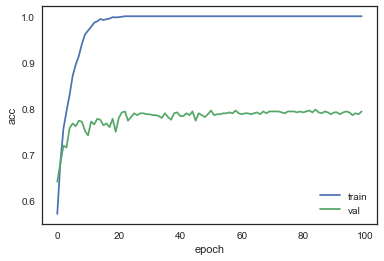

In [52]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [53]:
p=lm_fc1.predict(X_fc1_test)
p = np.squeeze(p)
pred = np.argmax(p, axis=-1)
conf = confusion_matrix(t_fc1, pred)

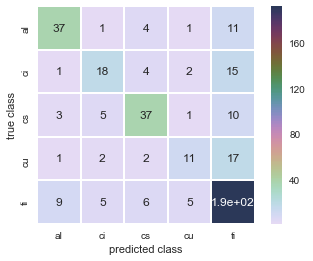

In [54]:
# preprocess data the same way
evaluate_confusion_matrix(lm_fc1, X_fc1_test, t_fc1)

In [ ]:
lm_fc2 = linear_softmax_classifier(n_classes=5, input_dim=4096)
opt = optimizers.Adam(lr=0.001)
lm_fc2.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

target = np_utils.to_categorical(np.array(class_ids))

# shuffle training data to get shuffled validation data
initial_shuf = np.random.permutation(N)
X_fc2 = fc2_raw[initial_shuf]
y_fc2 = np.array(class_ids)[initial_shuf]
label = target[initial_shuf]

hist = lm_fc2.fit(X_fc2, label, validation_split=0.2, epochs=20)

In [ ]:
metric = 'acc' # 'loss' | 'acc'
plt.plot(hist.epoch, hist.history[metric], label='train')
plt.plot(hist.epoch, hist.history['val_{}'.format(metric)], label='val')
plt.xlabel('epoch')
plt.ylabel(metric)
plt.legend()

In [ ]:
evaluate_confusion_matrix(lm_fc1, X_fc2[0:200], y_fc2[0:200])

# Take the middle output of fc1 fitting 

In [55]:
from keras.models import Model
 
model = lm_fc1  # create the original model
 
layer_name = 'mid'
intermediate_layer_model = Model(input=model.input,
                                output=model.get_layer(layer_name).output)
intermediate_output = intermediate_layer_model.predict(X_fc1)

/Library/Frameworks/Python.framework/Versions/2.7/lib/python2.7/site-packages/ipykernel/__main__.py:7: UserWarning: Update your `Model` call to the Keras 2 API: `Model(outputs=Tensor("mi..., inputs=Tensor("in...)`


(-37.930821763621672,
 85.050563502695454,
 -46.468038142348057,
 103.02116597376597)

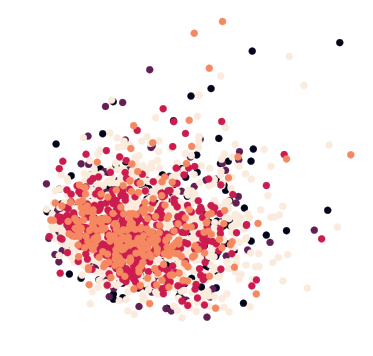

In [56]:
from sklearn.decomposition import PCA
pca_model = PCA(n_components=2)

x_pca = pca_model.fit_transform(intermediate_output)
plt.figure(figsize=(6,6))
plt.scatter(x_pca[:,0], x_pca[:,1], c=class_ids)
plt.axis('off')

In [59]:
from ntsne import ntsne
from sklearn.decomposition import PCA
pca_model=PCA(n_components=20)
x_pca=pca_model.fit_transform(intermediate_output)
x_tsne=ntsne.tsne(x_pca)
plt.figure(figsize=(6,6))
plt.scatter(x_tsne[:,0],x_tsne[:,1],c=class_ids)
plt.axis('off')
plt.savefig('ntsne.png')

AttributeError: 'module' object has no attribute 'which'

In [213]:
def image_montage(X, images, bordercolors, mapsize=8192, thumbsize=256, bordersize=4, verbose=False):
    """ make image maps in an embedding space """

    halfthumbsize = int((thumbsize + 2*bordersize)/2)
    map_shape = np.array([mapsize,mapsize,3])
    imagemap = np.ones(map_shape)

    # rescale max distance from origin to 1
    scale = np.max(np.abs(X[:,0:2]))

    # choose some random images to draw
    # sel = np.random.choice(range(keys.size), replace=False, size=2000)

    for ids, image in enumerate(images):

        # get image position
        pos = X[ids][:2]
    
        # load image
        with warnings.catch_warnings():
            warnings.simplefilter('ignore', UserWarning)
            im = images[ids,:,:]

        # crop arbitrarily to square aspect ratio
        mindim = min(im.shape)
        cropped = im[:mindim,:mindim]
    
        # make thumbnail
        thumbnail = skimage.transform.resize(cropped, (thumbsize,thumbsize), order=1)

        # convert to float+color -- float enables use of marker value (-1)
        thumbnail = skimage.img_as_float(thumbnail)
        thumbnail = skimage.color.gray2rgb(thumbnail)

        # add a colored border
        bordercolor = bordercolors[ids]
        thumbnail = np.lib.pad(thumbnail, ((bordersize,bordersize), (bordersize,bordersize), (0,0)),
                               'constant', constant_values=(-1,-1))
        thumbnail[thumbnail[:,:,0] == -1] = bordercolor

        # map position to image coordinates with buffer region
        # x,y = np.round(pos/scale * ((mapsize-(thumbsize+3+bordersize))/2) + (mapsize/2)).astype(int)
        x,y = np.round(pos/scale * ((mapsize-(thumbsize+10+bordersize))/2) + (mapsize/2)).astype(int)
        x = mapsize-x # image convention -- match scatter plot
        # place thumbnail into image map
        if verbose:
            print(thumbnail.shape)
            print(halfthumbsize*2)
            print('({},{})'.format(x,y))
        imagemap[x-(halfthumbsize):x+(halfthumbsize),y-(halfthumbsize):y+(halfthumbsize),:] = thumbnail

    return imagemap

In [214]:
x_color=np.zeros([N,1,1,3])
for i in range(0, N):
    x_color[i,0,0,:]=np.ones([1,1,3])*y[i]*(255.0/18)

In [215]:
import warnings
warnings.filterwarnings("ignore")

colors=[np.array([1, 1, 1]) for image in X]
mont=image_montage(x_tsne, x_color, bordercolors=colors)
plt.imshow(mont)

KeyboardInterrupt: 

In [ ]:
mont_max=np.max(mont)
for i in range(0, 8192):
    for j in range(0, 8192):
        for k in range(0, 3):
            mont[i, j, k]=int(mont[i, j, k]/mont_max*255.0)

skimage.io.imsave('tsne-map.png', mont)

In [ ]:
mont.shape

In [37]:
X.shape

(4315, 224, 224)